In [40]:

from IPython import display
display.clear_output()
import numpy as np
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import torch
from IPython.display import display, Image
from pathlib import Path
import cv2


Ultralytics YOLOv8.2.2 🚀 Python-3.8.0 torch-2.2.1 CPU (Apple M1)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 286.4/460.4 GB disk)


In [8]:
from roboflow import Roboflow
rf = Roboflow(api_key="FPMUpkcgXPXar7iXvDot")
project = rf.workspace("um-ajvmw").project("kneeoa-2")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.2, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to kneeOA-2-1 in yolov8:: 100%|██████████| 1224/1224 [00:00<00:00, 2158.93it/s]


In [21]:
model = YOLO("best.pt")

In [67]:
with torch.no_grad():
    results = model.predict(task="segment", source="9003175L.png", conf=0.25, hide_labels=True, show_conf=False, save=True, augment=False, boxes=False) 

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_labels' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_boxes' instead.

image 1/1 /Users/namle/Desktop/SegJSW/9003175L.png: 640x640 1 femur, 1 tibia, 3145.5ms
Speed: 10.2ms preprocess, 3145.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict4


In [ ]:
res_img = cv2.imread("/Users/namle/Desktop/SegJSW/runs/segment/predict4/9997856L.png")


In [464]:
contours = []
upper_mask = np.zeros(img.shape[:2], np.uint8)
lower_mask = np.zeros(img.shape[:2], np.uint8)
b_mask = np.zeros(img.shape[:2], np.uint8)
for r in results:
    
    img = np.copy(r.orig_img)
    img_name = Path(r.path).stem  # source image base-name
    
    for ci, c in enumerate(r):
        label = c.names[c.boxes.cls.tolist().pop()]
        
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        contours.append(contour)
        _ = cv2.drawContours(b_mask, [contours[0]], -1, 255, 1)
        mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
        # res.append(mask3ch)
        isolated = cv2.bitwise_and(mask3ch, img)



    _ = cv2.drawContours(upper_mask, [contours[0]], -1, 255, 1)
    _ = cv2.drawContours(lower_mask, [contours[1]], -1, 255, 1)
        
nonzero = b_mask.nonzero() 
nonzero_upper = upper_mask.nonzero() 
nonzero_lower = lower_mask.nonzero()     
        

        

In [465]:
upper_point = []
lower_point = []
point =[]
for i in range(nonzero_upper[1].shape[0]):
    upper_point.append([nonzero_upper[1][i], nonzero_upper[0][i]])
for i in range(nonzero_lower[1].shape[0]):
    lower_point.append([nonzero_lower[1][i], nonzero_lower[0][i]])
for i in range(nonzero[1].shape[0]):
    point.append([nonzero[1][i], nonzero[0][i]])


upper_point = np.array(upper_point)
lower_point = np.array(lower_point)
point  = np.array(point)

In [466]:

x_min_upper = np.min(upper_point[:,0])
x_max_upper = np.max(upper_point[:,0])
x_min_lower =np.min(lower_point[:,0])
x_max_lower =   np.max(lower_point[:,0])

y_min_upper = np.min(upper_point[:,1])
y_max_upper = np.max(upper_point[:,1])
y_min_lower =np.min(lower_point[:,1])
y_max_lower =   np.max(lower_point[:,1])

x_min = np.min([x_min_upper,x_min_lower])
x_max = np.min([x_max_upper,x_max_lower])

delete bottom and top line


In [468]:
upper_point = [p for p in list(upper_point) if p[1]!=1]
lower_point = [p for p in list(lower_point) if p[1]!=223]

Get 4 point 

In [490]:
p_intersect = []
for p in upper_point:
    if p[1] == y_min_lower:
        if  not p_intersect: 
            p_intersect.append(p)
        else:
            if abs(p[0] - p_intersect[-1][0])>=10:
                p_intersect.append(p)
            


In [504]:
x_min_left = max(p_intersect[0][0],x_min_upper,x_min_lower)
x_max_left= p_intersect[1][0]
x_min_right= p_intersect[2][0]
x_max_right = min(p_intersect[3][0],x_max_upper,x_max_lower)

In [540]:
upper_point = sorted(upper_point, key=lambda x: x[0])
lower_point = sorted(lower_point, key=lambda x: x[0])


In [541]:
upper_left = []
upper_right = []
lower_left = []
lower_right = []

for p in upper_point:
    if p[1]>100 and  p[0] in range(x_min_left,x_max_left):
        upper_left.append(p)
for p in upper_point:
    if p[1]>100 and p[0] in range(x_min_right,x_max_right):
        upper_right.append(p)
for p in lower_point:
    if p[1]<150 and p[0] in range(x_min_left,x_max_left):
        lower_left.append(p)
for p in lower_point:
    if p[1]<150  and p[0] in range(x_min_right,x_max_right):
        lower_right.append(p)
        

In [537]:
test = np.zeros(img.shape[:2], np.uint8)
for point in lower_right:
    cv2.circle(test, (point[0], point[1]), radius=1, color=(255), thickness=1)
for point in lower_left:
    cv2.circle(test, (point[0], point[1]), radius=1, color=(255), thickness=1)
for point in upper_right:
    cv2.circle(test, (point[0], point[1]), radius=1, color=(255), thickness=1)
for point in upper_left:
    cv2.circle(test, (point[0], point[1]), radius=1, color=(255), thickness=1)


In [547]:
len(lower_right)

50

In [551]:
isolated.shape


(224, 224, 3)

: 

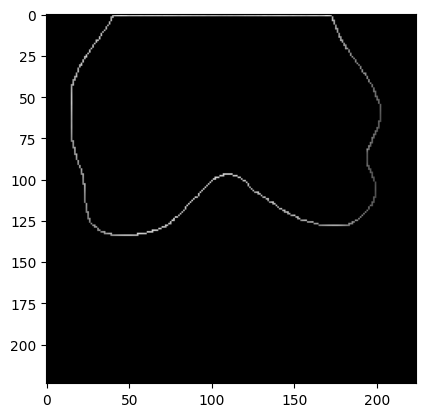

In [550]:
plt.imshow(isolated)

In [549]:
test = np.array(upper_left)

In [545]:
uni = np.unique(

[array([ 25, 120]),
 array([ 25, 121]),
 array([ 25, 122]),
 array([ 25, 123]),
 array([ 25, 124]),
 array([ 26, 124]),
 array([ 26, 125]),
 array([ 26, 126]),
 array([ 27, 127]),
 array([ 28, 128]),
 array([ 29, 128]),
 array([ 29, 129]),
 array([ 30, 129]),
 array([ 31, 130]),
 array([ 31, 131]),
 array([ 32, 131]),
 array([ 33, 132]),
 array([ 34, 132]),
 array([ 35, 132]),
 array([ 35, 133]),
 array([ 36, 133]),
 array([ 37, 133]),
 array([ 38, 133]),
 array([ 39, 133]),
 array([ 39, 134]),
 array([ 40, 134]),
 array([ 41, 134]),
 array([ 42, 134]),
 array([ 43, 134]),
 array([ 44, 134]),
 array([ 45, 134]),
 array([ 46, 134]),
 array([ 47, 134]),
 array([ 48, 134]),
 array([ 49, 134]),
 array([ 50, 134]),
 array([ 51, 134]),
 array([ 52, 134]),
 array([ 53, 134]),
 array([ 54, 134]),
 array([ 55, 133]),
 array([ 55, 134]),
 array([ 56, 133]),
 array([ 57, 133]),
 array([ 58, 133]),
 array([ 59, 133]),
 array([ 60, 133]),
 array([ 61, 132]),
 array([ 62, 132]),
 array([ 63, 132]),


In [543]:
for i in range((x_max_left-x_min_left)//5):
    print("1")
    point1 = upper_left[i*5]
    point2 = lower_left[i*5]
    cv2.line(test, point1, point2, color=(255), thickness=1)

1
1
1
1
1
1
1
1
1
1
1


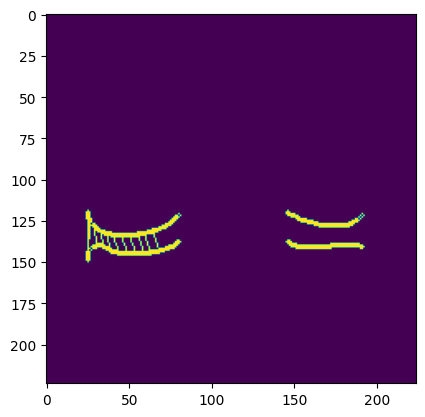

In [544]:
plt.imshow(test)

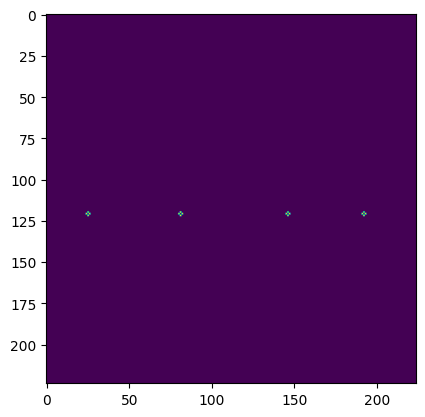

In [508]:
test = np.zeros(img.shape[:2], np.uint8)
# for point in upper_point:
#     cv2.circle(test, (point[0], point[1]), radius=1, color=(255), thickness=1)
for point in p_intersect:
    cv2.circle(test, (point[0], point[1]), radius=1, color=(122), thickness=1)
plt.imshow(test)

In [388]:
nonzero_upper.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [336]:
import matplotlib.pyplot as plt

In [364]:
upper.shape    

(564, 2)

In [365]:
lower.shape

(454, 2)

In [359]:
nonzero = b_mask.nonzero() 

In [363]:
nonzero[1].shape

(1100,)

In [373]:
for i in range(nonzero[1].shape[0]):
    cv2.circle(isolated, (nonzero[1][i], nonzero[0][i]), radius=1, color=(255,255,0), thickness=1)

In [375]:
cv2.imshow("test",isolated)
cv2.waitKey(0)

113

In [368]:
pts = np.where(b_mask == 255)

In [321]:
b_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [320]:
pts[0].shape

(301,)

In [316]:

# Create a blank mask
height, width = 400, 400
b_mask = np.zeros((height, width), dtype=np.uint8)

# Draw a line
start_point = (50, 50)
end_point = (350, 350)
line_thickness = 1
line_color = 255
cv2.line(b_mask, start_point, end_point, line_color, line_thickness)

# Threshold the mask to set non-zero values to 255
_, b_mask = cv2.threshold(b_mask, 1, 255, cv2.THRESH_BINARY)

# Check the pixel values along the line
y_min_lower = min(start_point[1], end_point[1])
print(b_mask[:,y_min_lower])  # Should print 255 for the pixels along the line





[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 

In [314]:
print(b_mask[:,y_min_lower])

[  0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255]


In [315]:
print(b_mask[:,y_min_lower+2])

[  0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255]


In [311]:
x_intersect = []
for i in range(224):
    if(b_mask[i][y_min_lower] != 0):
        x_intersect.append(i)

In [312]:
y_min_lower

121

In [324]:
print(test[20,20])

0


In [323]:
height, width = 400, 400
test = np.zeros((height, width), dtype=np.uint8)
cv2.circle(test, (20, 20), radius=3, color=(0, 255, 255), thickness=5)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [313]:
x_intersect

[1, 102, 121, 223]

In [292]:
b_mask[:,y_min_lower]

array([  0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   

In [302]:
x_intersect

[1, 102, 121, 223]

In [ ]:
upper_point = []
for x in range(x_min,x_max):
    for y in range()
    if b_mask[

In [271]:
b_mask[:,y_min_lower]

array([  0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   

In [247]:
start_point = (x_min_upper,y_min_lower)  # X-coordinate, Y-coordinate
end_point = (x_max_upper,y_min_lower)   # X-coordinate, Y-coordinate

# Define line color (BGR format)
color = (255, 0, 0)  # Blue color

# Draw the line with thickness of 2 pixels
thickness = 1
image = cv2.line(b_mask, start_point, end_point, color, thickness)

In [267]:
for x in x_intersect:
    cv2.circle(mask3ch, (x, y_min_lower), radius=3, color=(0, 255, 255), thickness=5)

In [296]:
isolated = cv2.cvtColor(isolated, cv2.COLOR_BGR2GRAY)

In [298]:
cv2.imshow('image',isolated)
cv2.waitKey(0)

113

In [297]:
isolated.shape

(224, 224)

In [146]:
upper.shape

(564, 2)

In [356]:
upper[:,1].shape

(564,)

In [181]:
newupper = []

In [182]:
count = 0

In [183]:
for point in upper[:]:
    count+=1
    if point[1]!= 1 and point[1]!=224:
        newupper.append(point)
newupper=np.array(newupper)

In [184]:
print(count)

564


In [185]:
newupper.shape

(558, 2)

In [156]:
lower.shape

(454, 2)

In [153]:
upper.shape

(564, 2)

In [154]:
upper[0]

array([41,  1], dtype=int32)

In [ ]:
newcontour = []